In [26]:
import argparse
import csv

import math
import multiprocessing
import os
import random
import sys
from timeit import default_timer as timer
from operator import itemgetter
#import dill
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from alipy.data_manipulate.al_split import split
from alipy.experiment.al_experiment import AlExperiment
from alipy.index import IndexCollection
import timeit
import matplotlib.pyplot as plt
import seaborn as sns

font_size = 8

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    "axes.labelsize": font_size,
    "font.size": font_size,
    "legend.fontsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "xtick.bottom":True,
    "figure.autolayout": True,
    
}

sns.set_style('white')
sns.set_context("paper")
plt.rcParams.update(tex_fonts)




# https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

width = 505.89


df = pd.read_csv("result.csv")

# rename to more meaningful names
df['strategy'] = df['strategy'].replace({
    "QueryInstanceUncertainty{'measure': 'margin'}":"MM", 
    "QueryInstanceUncertainty{'measure': 'least_confident'}":"LC", 
    "QueryInstanceUncertainty{'measure': 'entropy'}":"Ent", 
    "QueryInstanceGraphDensity{}":"GD", 
    "QueryInstanceRandom{}":"Rand", 
    "QueryInstanceQUIRE{}":"QUIRE", 
    "QueryInstanceQBC{}":"QBC", 
    "QureyExpectedErrorReduction{}":"EER", 
    "QueryInstanceLAL{}": "LAL",
    "QueryInstanceSPAL{}": "SPAL",
    "QueryInstanceBMDR{}": "BMDR",
    
      "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '../trained strategies/single.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 1, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False}": 'NN Single',
      "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '../trained strategies/single.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 1, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": 'NN Single cos',
      "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '../trained strategies/batch.pickle', 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False}": 'NN Batch',
})


# for large datasets the cosine variants work better than the single ones
large_datasets_where_cosine_is_better_for_single = [7,8,10,11]

for dataset_id in large_datasets_where_cosine_is_better_for_single:
    df = df[(df.strategy != 'NN Single') | (df.dataset_id != dataset_id)]

df = df[(df.strategy != 'NN Single cos') | (df.dataset_id.isin(large_datasets_where_cosine_is_better_for_single))]


df['strategy'] = df['strategy'].replace({
      'NN Single cos': 'NN Single',
})


df = df[df.strategy != 'NN Batch']
df['strategy'] = df['strategy'].replace({'NN Single': 'ImitAL'})

df = df[df.dataset_id != 0]

df

,numqdata,round,init_labeled_size,num_of_queries,cost,performance,performance_plus_minus,dataset_id,strategy_id,dataset_random_seed,...,n_redundant,n_repeated,n_classes,n_clusters_per_class,weights,flip_y,class_sep,hypercube,scale,random_state
0,48,0,2,10,0,0.929415,0.014659,1,3,2,...,0,0,2,0,0,0.0,0.0,0,0.0,2
1,48,0,2,10,0,0.903619,0.085935,1,2,9,...,0,0,2,0,0,0.0,0.0,0,0.0,9
2,48,0,2,10,0,0.840795,0.169882,1,3,4,...,0,0,2,0,0,0.0,0.0,0,0.0,4
3,48,0,2,10,0,0.903605,0.041869,1,2,7,...,0,0,2,0,0,0.0,0.0,0,0.0,7
4,48,0,2,10,0,0.787143,0.217998,1,2,6,...,0,0,2,0,0,0.0,0.0,0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19519,250,0,2,50,0,0.763469,0.024513,2,3,100,...,0,0,2,0,0,0.0,0.0,0,0.0,100
19520,250,0,2,50,0,0.763469,0.024513,2,3,100,...,0,0,2,0,0,0.0,0.0,0,0.0,100
19521,48,0,2,10,0,0.871350,0.067123,1,3,100,...,0,0,2,0,0,0.0,0.0,0,0.0,100
19522,48,0,2,10,0,0.871350,0.067123,1,3,100,...,0,0,2,0,0,0.0,0.0,0,0.0,100


<AxesSubplot:>

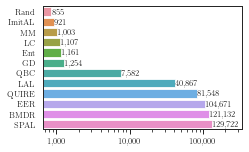

In [20]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, "{:,.0f}".format(value), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - 0.15
                value = int(p.get_width())
                ax.text(_x, _y, "{:,.0f}".format(value), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


plt.figure(figsize=set_size(width, fraction=0.5))
from numpy import median
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator


df_dur = df.groupby(['strategy', 'dataset_id'])['duration'].mean().to_frame()
df_dur = df_dur.reset_index()  


df_dur2 =  df.groupby(['strategy'])['duration'].mean().to_frame()

timout_duration = 604800
#timout_duration = 259200

# timeout
df_dur = df_dur.append({'strategy':'LAL', 'dataset_id':'8', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'EER', 'dataset_id':'8', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'QUIRE', 'dataset_id':'8', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'BMDR', 'dataset_id':'8', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'SPAL', 'dataset_id':'8', 'duration':timout_duration}, ignore_index=True)

df_dur = df_dur.append({'strategy':'BMDR', 'dataset_id':'7', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'SPAL', 'dataset_id':'7', 'duration':timout_duration}, ignore_index=True)


df_dur = df_dur.append({'strategy':'EER', 'dataset_id':'11', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'QUIRE', 'dataset_id':'11', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'BMDR', 'dataset_id':'11', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'SPAL', 'dataset_id':'11', 'duration':timout_duration}, ignore_index=True)


df_hist_new = pd.DataFrame(columns=['strategy', 'duration'])
for strategy in df.strategy.unique():
    df_hist_new = df_hist_new.append({
        'strategy':strategy, 
        'duration': df_dur.loc[df_dur['strategy'] ==strategy]['duration'].mean()
    }, ignore_index=True)


df_hist_new = df_hist_new.sort_values(by=['duration'])
g = sns.barplot(data=df_hist_new, x="duration", y="strategy")#, ci=68, capsize=.3)#, fill=True, common_norm=False, alpha=.5, linewidth=0)
show_values_on_bars(g, "h", 10.4)
g.set_xscale("log")
#g.xaxis.set_minor_locator(AutoMinorLocator(5))

#print(g.get_xlim())
g.set_xlim(g.get_xlim()[0],g.get_xlim()[1]+170000)

import matplotlib.ticker
g.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
g.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
g.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

g.xaxis.tick_bottom()
g.set_xlabel("")
#g.set_xlabel("duration in s (walltime)")
g.set_ylabel("")
g.get_figure().savefig('performance.pdf', format='pdf', bbox_inches='tight')
g


In [28]:
from tabulate import tabulate
dataset_to_id= {
        1: "fertility",
    2: "german",
    3: "diabetes",
    4: "ionosphere",
    5: "planning",
    6: "australian",
    7: "DWTC",
    8: "EMNIST",
    9: "glass",
    10: "olivetti",
    11: "CIFAR-10",
    12: "haberman",
    13: "zoo",
    14: "flags",
    15: "heart",
    
}
print(df['dataset_id'].unique())


dataset_names = ['strategy'] + [dataset_to_id[id] for id in df['dataset_id'].unique()]
strategy_results = []
strategy_results.append(dataset_names)

def get_ranks(l):
    uniques = np.unique(l)
    argssorted = np.flip(np.argsort(uniques))
    mapping = dict(zip(uniques, argssorted))
    ranks = [mapping[x] for x in l]
    
    m2 = {}
    last_value = -1
    increase = 0
    for i, v in enumerate(sorted(ranks)):
        if last_value == v:
            increase += 1
            m2[v] = v
        else:
            m2[v] = v+increase
        last_value = v
    
    # uncomment to calculate ranks like : 0,1,1,3,4,5,5,7, so add +1 after a tie
    # if it is uncommented we do not add an extra +1 after a tie (as it is done in the paper)
    # as you can see, this has no influence of the superior ranking performance of NN Single, it only punishes all other techniques more
    #ranks = [m2[x] for x in ranks]
    return ranks

for strategy in df['strategy'].unique():
    results = [strategy]
    for dataset in df['dataset_id'].unique():
        results.append("{:.40f}".format(df.loc[(df['dataset_id']==dataset) & (df['strategy']==strategy)]['f1_auc'].mean()))
         
        results = [r if r != "nan" else -0 for r in results] 
     
    strategy_results.append(results)
    
results_df = pd.DataFrame(strategy_results[1:], columns=strategy_results[0])
results_df = results_df.set_index("strategy")
results_df = results_df.replace(-1, np.NaN)
results_df = results_df.apply(pd.to_numeric)

results_df['mean'] = results_df.T.mean(skipna=True)


ranking_only_table = []
transposed_results = list(map(list, zip(*strategy_results)))
new_results = [transposed_results[0]]
for row in transposed_results[1:]:
    row_sorting = get_ranks(np.array(row[1:]))
    row = row[:1] + ["{:.1%} ({})".format(float(a),b) for a,b in zip(row[1:], row_sorting)]
    new_results.append(row)
    ranking_only_table.append(row[:1] + row_sorting)

row = ["mean %"] + results_df['mean'].to_list()
row_sorting = get_ranks(np.array(row[1:]))

row = row[:1] + ["{:.1%} ({})".format(float(a),b) for a,b in zip(row[1:], row_sorting)]
new_results.append(row)


ranking_only_table = [transposed_results[0]] + ranking_only_table
new_results.append(["mean (r)"] + ["{:1.2f}".format(sum(r)/len(r)) for r in list(map(list, zip(*ranking_only_table[1:])))[1:]])


# sort colmuns manually
df2 = pd.DataFrame(new_results[1:], columns=new_results[0])
df2 = df2[['strategy', 'ImitAL', 'MM', 'QBC', 'LC', 'GD', 'BMDR', 'Ent', 'LAL', 'SPAL', 'EER', 'QUIRE','Rand']]

order = ['strategy'] + sorted([v for v in dataset_to_id.values()], key=lambda v: v.upper()) + ['mean %', 'mean (r)']
lol = [df2.columns.values.tolist()] + df2.values.tolist()
lol = sorted(lol, key=lambda l: order.index(l[0]))

with open('ali_f1auc_table.tex', "w") as f:
    tex_code = tabulate(lol, headers="firstrow", tablefmt="latex_booktabs")
    splitted = ["\\fontseries{b}\\selectfont{" + t[1:-1] + "}" if "(0)" in t else t for t in tex_code.split("&") ]
    
    
    tex_code = "&".join(splitted)
    tex_code = tex_code.replace("llllllllllllll", "L{1.1cm}cccccccccccccc")
    
    tex_code = tex_code.replace("tabular", "tabularx")
    tex_code = tex_code.replace("CIFAR-10", "\mbox{CIFAR-10}")

    tex_code = tex_code.replace("begin{tabularx}", "begin{tabularx}{\linewidth}")

    tex_code = tex_code.replace("mean \%", "\\midrule \n mean \%")
    tex_code = tex_code.replace(" \\% ", "~~~")
    tex_code = tex_code.replace("\\% ", " ")
    tex_code = tex_code.replace("~~~", " \\%")
    for ind in range(0,100):
        tex_code = tex_code.replace(" 0.0 ("+str(ind)+")", "")
        
    tex_code = tex_code.replace("1.36", "\\fontseries{b}\\selectfont{1.36}")
    tex_code = tex_code.replace(" \\\\", "\\\\")
    tex_code = tex_code.replace("cc", "rr")
    tex_code = tex_code.replace("strategy", "")
    f.write(tex_code)
    
tabulate(lol, headers="firstrow", tablefmt="html")


[ 1  3  2 12 15  4  5  6  7  8  9 10 11 13 14]


strategy,ImitAL,MM,QBC,LC,GD,BMDR,Ent,LAL,SPAL,EER,QUIRE,Rand
australian,85.4% (0),85.4% (2),85.3% (3),85.4% (1),85.2% (4),85.1% (6),85.4% (2),85.2% (5),84.3% (9),84.6% (8),76.2% (10),84.9% (7)
CIFAR-10,37.0% (0),36.9% (1),36.0% (4),35.9% (5),36.3% (3),0.0% (8),35.7% (6),34.9% (7),0.0% (8),0.0% (8),0.0% (8),36.8% (2)
diabetes,74.3% (3),74.3% (4),74.4% (2),74.3% (5),75.0% (0),74.7% (1),74.3% (4),74.3% (6),73.9% (9),74.2% (8),66.5% (10),74.2% (7)
DWTC,74.9% (0),74.7% (1),71.7% (5),71.0% (6),65.1% (8),0.0% (10),68.5% (7),72.2% (4),0.0% (10),72.8% (3),53.4% (9),72.9% (2)
EMNIST,69.1% (1),69.5% (0),63.4% (3),61.6% (4),43.8% (6),0.0% (7),59.2% (5),0.0% (7),0.0% (7),0.0% (7),0.0% (7),66.1% (2)
fertility,88.5% (3),87.9% (9),88.2% (5),88.0% (7),88.3% (4),88.6% (2),88.0% (8),88.0% (6),88.6% (1),86.6% (11),89.1% (0),87.4% (10)
flags,57.7% (0),56.6% (4),55.9% (8),55.4% (9),57.0% (2),57.4% (1),54.7% (10),55.9% (7),56.9% (3),56.0% (6),50.4% (11),56.2% (5)
german,75.7% (2),75.3% (10),75.5% (5),75.4% (8),76.2% (1),75.6% (4),75.4% (9),75.5% (6),76.5% (0),75.4% (7),70.9% (11),75.6% (3)
glass,69.0% (0),68.6% (1),67.5% (5),68.0% (2),66.4% (7),67.6% (4),66.3% (8),66.0% (9),61.7% (10),67.2% (6),48.2% (11),67.6% (3)
haberman,72.9% (4),72.9% (3),73.3% (0),72.9% (1),71.6% (7),71.6% (8),72.9% (2),72.3% (5),0.0% (11),72.0% (6),63.2% (10),71.5% (9)


# 

In [38]:
from tabulate import tabulate
import numpy as np
from scipy import stats

dataset_to_id= {
        1: "fertility",
    2: "german",
    3: "diabetes",
    4: "ionosphere",
    5: "planning",
    6: "australian",
    7: "DWTC",
    8: "EMNIST",
    9: "glass",
    10: "olivetti",
    11: "CIFAR-10",
    12: "haberman",
    13: "zoo",
    14: "flags",
    15: "heart",
    
}


dataset_names = ['strategy'] + [dataset_to_id[id] for id in df['dataset_id'].unique()]
strategy_results = []
strategy_results.append(dataset_names)

def get_ranks(l):
    uniques = np.unique(l)
    argssorted = np.flip(np.argsort(uniques))
    mapping = dict(zip(uniques, argssorted))
    ranks = [mapping[x] for x in l]
    
    m2 = {}
    last_value = -1
    increase = 0
    for i, v in enumerate(sorted(ranks)):
        if last_value == v:
            increase += 1
            m2[v] = v
        else:
            m2[v] = v+increase
        last_value = v
    
    # uncomment to calculate ranks like : 0,1,1,3,4,5,5,7, so add +1 after a tie
    # if it is uncommented we do not add an extra +1 after a tie (as it is done in the paper)
    # as you can see, this has no influence of the superior ranking performance of NN Single, it only punishes all other techniques more
    #ranks = [m2[x] for x in ranks]
    return ranks

dataset_to_compare = 'QUIRE'
interval = 1-0.9

print("all together")
a = df.loc[df['strategy']=='NN Single']['f1_auc'].to_numpy()
b = df.loc[df['strategy']==dataset_to_compare]['f1_auc'].to_numpy()
t, p = stats.ttest_ind(a,b)
print("t = " + str(t))
print("p = " + str(p))
if p < interval:
    print("Significant!")
else:
    print("Not significant")
    
a_s = []
b_s = []
    
for dataset in df['dataset_id'].unique():
    print(dataset_to_id[dataset])
    a = df.loc[(df['dataset_id']==dataset) & (df['strategy']=='NN Single')]['f1_auc'].to_numpy()
    b = df.loc[(df['dataset_id']==dataset) & (df['strategy']==dataset_to_compare)]['f1_auc'].to_numpy()
    a_s.append(np.mean(a))
    b_s.append(np.mean(b))
    

    ## Cross Checking with the internal scipy function
    t, p = stats.ttest_ind(a,b)
    #print("t = " + str(t))
    print("p = " + str(p))
    
    if p < interval:
        print("Significant!")
    else:
        print("Not significant")
    ### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.

    
    #print(df.loc[(df['dataset_id']==dataset) & (df['strategy']=='NN Single')]['f1_auc'].mean())
    #print(df.loc[(df['dataset_id']==dataset) & (df['strategy']=='MM')]['f1_auc'].mean())
    print()

print("Means")
    
t, p = stats.ttest_ind(a_s,b_s)
print("t = " + str(t))
print("p = " + str(p))
if p < interval:
    print("Significant!")
else:
    print("Not significant")
    

all together
t = 14.31369908879011
p = 7.016342322073623e-45
Significant!
fertility
p = 0.15764253153954605
Not significant

diabetes
p = 2.5169002061962217e-37
Significant!

german
p = 3.919011768629743e-15
Significant!

haberman
p = 1.5570115625436015e-15
Significant!

heart
p = 3.1853195739726803e-28
Significant!

ionosphere
p = 2.0895858911006804e-174
Significant!

planning
p = 0.582420257544612
Not significant

australian
p = 2.4209244924565232e-64
Significant!

DWTC
p = 3.0803137839845545e-100
Significant!

EMNIST
p = nan
Not significant

glass
p = 4.2105224697392785e-70
Significant!

olivetti
p = 3.857679791379383e-110
Significant!

CIFAR-10
p = nan
Not significant

zoo
p = 0.6849762356323811
Not significant

flags
p = 1.0964499693905069e-31
Significant!

Means
t = nan
p = nan
Not significant


/home/julius/.local/share/virtualenvs/ALiPy-yBTkQe9L/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/julius/.local/share/virtualenvs/ALiPy-yBTkQe9L/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/julius/.local/share/virtualenvs/ALiPy-yBTkQe9L/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/julius/.local/share/virtualenvs/ALiPy-yBTkQe9L/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
